In [4]:
import os
import pickle

import torch
import torch.nn as nn
import torch.optim as optim

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [5]:
data_dir = '../data'
results_dir = '../results'
task = 'next_step'

task_data_dir = data_dir
task_results_dir = os.path.join(results_dir, task)

In [24]:
# Set a random seed for reproducibility
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)

# Define the MLP model
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# Define the MLP model
class DeepMLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(DeepMLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.relu2 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.relu2(x)
        x = self.fc2(x)
        return x

# Function to calculate mae
def calculate_mae(outputs, labels):
    _, predicted = torch.max(outputs, 1)
    _, actual = torch.max(labels, 1)
    correct = (predicted - actual).abs().sum().item()
    return correct / labels.size(0)

def train_mlp(input_data, labels, val_data, val_labels, hidden_size=10, learning_rate=0.01, epochs=100, seed=42, gpu_device=None, l2_lambda=0.01, depth="shallow", print_step=100):
    # Set the seed for reproducibility
    set_seed(seed)

    # Set device to the specified GPU if available, otherwise CPU
    if gpu_device is not None and torch.cuda.is_available():
        device = torch.device(f"cuda:{gpu_device}")
    else:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    print(f"Using device: {device}")

    input_size = input_data.shape[1]
    output_size = labels.shape[1]

    # Initialize the model, loss function, and optimizer
    if depth == "shallow":
        model = MLP(input_size, hidden_size, output_size).to(device)
    elif depth == "deep":
        model = DeepMLP(input_size, hidden_size, output_size).to(device)
    else:
        raise Exception("Error in model depth provided.")
    
    criterion = nn.MSELoss()  # Assuming we're doing regression, adjust for classification if needed
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=l2_lambda)  # L2 regularization added via weight_decay

    # Convert input data and validation data to PyTorch tensors and move to device
    input_tensor = torch.FloatTensor(input_data).to(device)
    labels_tensor = torch.FloatTensor(labels).to(device)
    val_tensor = torch.FloatTensor(val_data).to(device)
    val_labels_tensor = torch.FloatTensor(val_labels).to(device)

    # Lists to store training and validation losses
    training_losses = []
    validation_losses = []
    training_accuracies = []
    validation_accuracies = []

    # Training loop
    for epoch in range(epochs):
        # Forward pass on training data
        model.train()
        outputs = model(input_tensor)
        loss = criterion(outputs, labels_tensor)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Store training loss
        training_losses.append(loss.item())

        # Calculate training accuracy
        train_accuracy = calculate_mae(outputs, labels_tensor)
        training_accuracies.append(train_accuracy)

        # Evaluate on the validation set
        model.eval()  # Set the model to evaluation mode
        with torch.no_grad():  # Disable gradient calculation
            val_outputs = model(val_tensor)
            val_loss = criterion(val_outputs, val_labels_tensor)

        # Store validation loss
        validation_losses.append(val_loss.item())

        # Calculate validation accuracy
        val_accuracy = calculate_mae(val_outputs, val_labels_tensor)
        validation_accuracies.append(val_accuracy)

        if (epoch + 1) % print_step == 0:
            print(f'Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}, Validation Loss: {val_loss.item():.4f}, Train MAE: {train_accuracy:.4f}, Val MAE: {val_accuracy:.4f}')
        
    return {"model": model,
            "training_losses": training_losses,
            "validation_losses": validation_losses,
            "training_acc": training_accuracies,
            "validation_acc": validation_accuracies}

# Function to evaluate the MLP on a test set
def evaluate_mlp(model, test_data, test_labels, device):
    model.eval()
    test_tensor = torch.FloatTensor(test_data).to(device)
    test_labels_tensor = torch.FloatTensor(test_labels).to(device)
    criterion = nn.MSELoss()

    with torch.no_grad():
        test_outputs = model(test_tensor)
        test_loss = criterion(test_outputs, test_labels_tensor)
        test_accuracy = calculate_mae(test_outputs, test_labels_tensor)

    print(f'Test Loss: {test_loss.item():.4f}, Test MAE: {test_accuracy:.4f}')

    return (test_loss.item(), test_accuracy, test_outputs.to('cpu'))

In [7]:
# # Example usage:
# # 2D input vectors and 2D output labels for training
# input_data = np.array([[0.5, 0.3], [0.2, 0.8], [0.9, 0.1], [0.7, 0.6]])
# labels = np.array([[0.1, 0.5], [0.4, 0.7], [0.3, 0.2], [0.6, 0.9]])

# # 2D validation vectors and 2D output labels for validation
# val_data = np.array([[0.4, 0.2], [0.3, 0.9]])
# val_labels = np.array([[0.2, 0.4], [0.5, 0.6]])

# # Train the MLP and track validation loss
# model, tl, vl = train_mlp(input_data, labels, val_data, val_labels, hidden_size=5, learning_rate=0.01, epochs=100, seed=42, gpu_device=3)

In [8]:
data_files = [f for f in os.listdir(task_data_dir) if f.endswith('csv') and f.startswith('predator')]
training_indices = [0,1,2,3]
validation_indices = [4,5,6,7]
testing_indices = [8,9]

# Set up training data
train_csv_files = [os.path.join(task_data_dir, data_files[i]) for i in training_indices]

training_dataframes = list()
for file in train_csv_files:
    df = pd.read_csv(file)
    training_dataframes.append(df)

data = pd.concat(training_dataframes, ignore_index=True)

training_data = {
    'inputs': data[["Prey", "Predator"]][:-1].to_numpy(),
    'labels': data[["Prey", "Predator"]][1:].to_numpy() 
}
print(training_data['inputs'].shape)

## Set up validation data
val_csv_files = [os.path.join(task_data_dir, data_files[i]) for i in validation_indices]

validation_dataframes = list()
for file in val_csv_files:
    df = pd.read_csv(file)
    validation_dataframes.append(df)

valdata = pd.concat(validation_dataframes, ignore_index=True)

validation_data = {
    'inputs': valdata[["Prey", "Predator"]][:-1].to_numpy(),
    'labels': valdata[["Prey", "Predator"]][1:].to_numpy(),
}
print(validation_data['inputs'].shape)

# Set up testing data
test_csv_files = [os.path.join(task_data_dir, data_files[i]) for i in testing_indices]

testing_dataframes = list()
for file in test_csv_files:
    df = pd.read_csv(file)
    testing_dataframes.append(df)

testdata = pd.concat(testing_dataframes, ignore_index=True)

testing_data = {
    'inputs': testdata[["Prey", "Predator"]][:-1].to_numpy(),
    'labels': testdata[["Prey", "Predator"]][1:].to_numpy(),
}
print(testing_data['inputs'].shape)

split_string = f"{','.join(map(str,training_indices))}:{','.join(map(str,validation_indices))}:{','.join(map(str,testing_indices))}"
print(split_string)

(3999, 2)
(3999, 2)
(1999, 2)
0,1,2,3:4,5,6,7:8,9


In [14]:
epochs = 100000
seed = 42
l2_lambda = 0.01
lr = 0.01
hidden_size=3
depth = "deep"
gpu_device = 3
suffix = f"{epochs}-{seed}-{l2_lambda}-{lr}-{hidden_size}-{depth}-{split_string}"

In [15]:
# Train!
results = train_mlp(training_data['inputs'], 
                  training_data['labels'], 
                  validation_data['inputs'], 
                  validation_data['labels'], 
                  hidden_size=hidden_size, 
                  learning_rate=lr, 
                  epochs=epochs, 
                  seed=seed,
                  gpu_device=gpu_device,
                  l2_lambda=l2_lambda,
                  depth=depth,
                  print_step=1000)

# Evaluate the model on the test set
test_loss, test_acc, test_outputs = evaluate_mlp(results["model"], testing_data['inputs'], testing_data['labels'], 
             device=torch.device(f"cuda:{gpu_device}") if torch.cuda.is_available() else torch.device("cpu"))

results['test_loss'] = test_loss
results['test_acc'] = test_acc

# Save the results as a pickled object
with open(os.path.join(task_results_dir, f'mlp_training_results_{suffix}.pkl'), 'wb') as f:
    pickle.dump(results, f)

Using device: cuda:3
Epoch [1000/100000], Loss: 7.5519, Validation Loss: 9.0979, Train MAE: 0.1468, Val MAE: 0.0475
Epoch [2000/100000], Loss: 3.8595, Validation Loss: 7.0709, Train MAE: 0.0635, Val MAE: 0.1208
Epoch [3000/100000], Loss: 3.3896, Validation Loss: 6.5492, Train MAE: 0.0543, Val MAE: 0.0965
Epoch [4000/100000], Loss: 3.3355, Validation Loss: 6.4966, Train MAE: 0.0500, Val MAE: 0.0920
Epoch [5000/100000], Loss: 3.3226, Validation Loss: 6.4021, Train MAE: 0.0513, Val MAE: 0.0920
Epoch [6000/100000], Loss: 2.9468, Validation Loss: 5.7114, Train MAE: 0.0433, Val MAE: 0.0770
Epoch [7000/100000], Loss: 2.8812, Validation Loss: 5.6143, Train MAE: 0.0243, Val MAE: 0.0745
Epoch [8000/100000], Loss: 2.8235, Validation Loss: 5.5972, Train MAE: 0.0273, Val MAE: 0.0695
Epoch [9000/100000], Loss: 2.7994, Validation Loss: 5.6067, Train MAE: 0.0360, Val MAE: 0.0760
Epoch [10000/100000], Loss: 2.7836, Validation Loss: 5.5467, Train MAE: 0.0385, Val MAE: 0.0768
Epoch [11000/100000], Loss: 

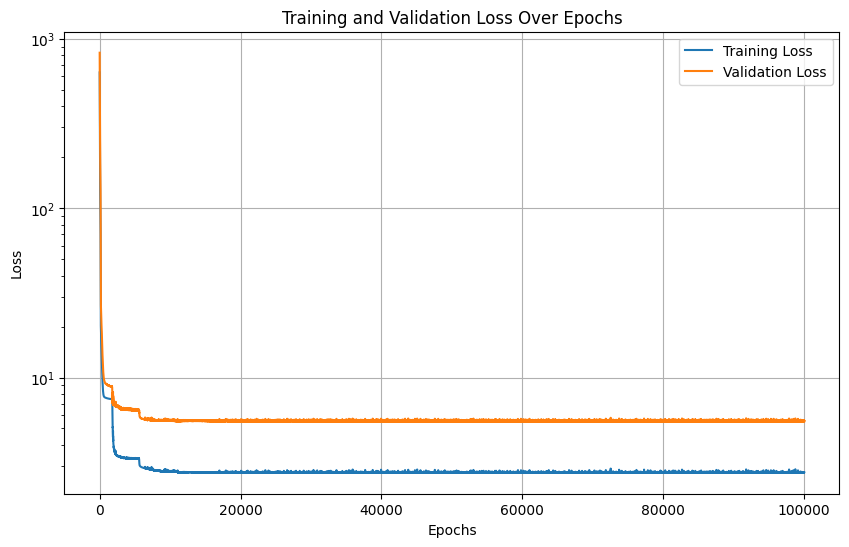

In [18]:
# Plot the training and validation losses
plt.figure(figsize=(10, 6))
plt.plot(range(epochs), results["training_losses"], label='Training Loss')
plt.plot(range(epochs), results["validation_losses"], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.yscale('log')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid()
plt.savefig(os.path.join(task_results_dir, f'pp_mlp_loss_{suffix}.png'))

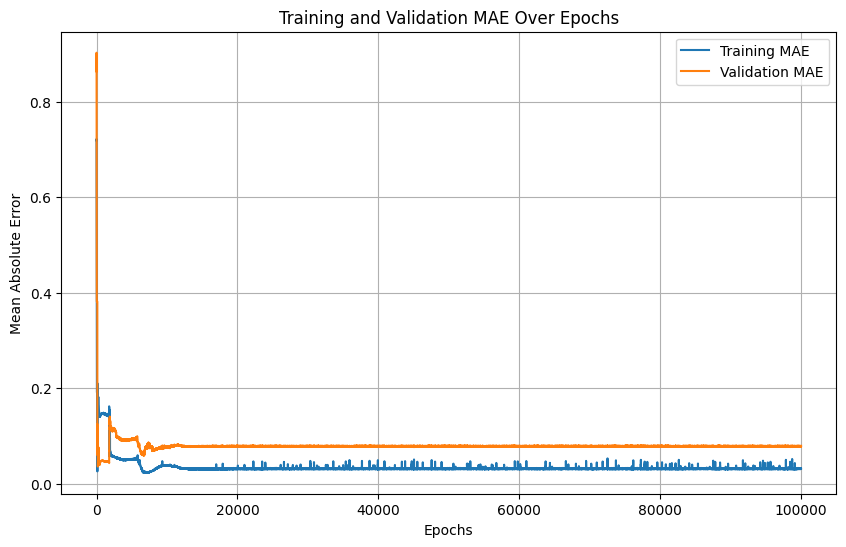

In [19]:
# Plot the training and validation accuracies
plt.figure(figsize=(10, 6))
plt.plot(range(epochs), results["training_acc"], label='Training MAE')
plt.plot(range(epochs), results["validation_acc"], label='Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error')
# plt.ylim(0.8, 1.0)
plt.title('Training and Validation MAE Over Epochs')
plt.legend()
plt.grid()
plt.savefig(os.path.join(task_results_dir, f'pp_mlp_acc_{suffix}.png'))

In [25]:
test_loss, test_acc, test_outputs = evaluate_mlp(results["model"], testing_data['inputs'], testing_data['labels'], 
             device=torch.device(f"cuda:{gpu_device}") if torch.cuda.is_available() else torch.device("cpu"))


Test Loss: 31.4077, Test MAE: 0.0870


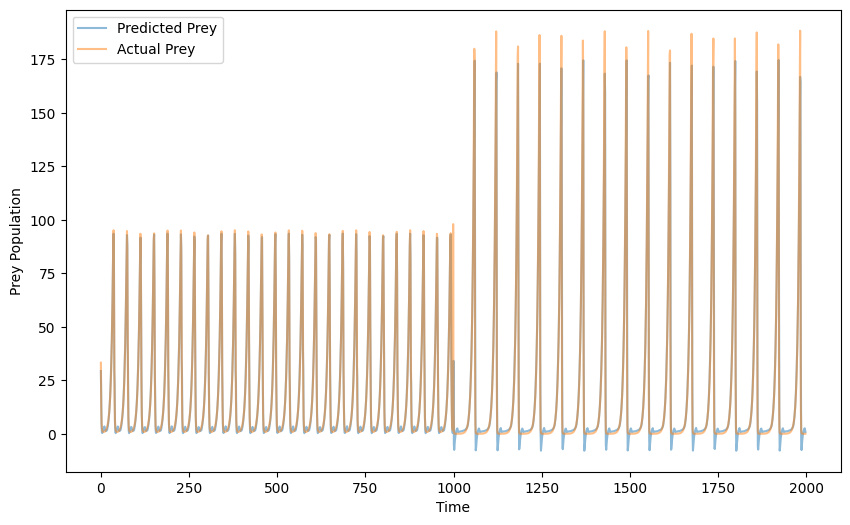

In [42]:
plt.figure(figsize=(10, 6))
plt.plot(range(test_outputs.shape[0]), test_outputs[:,0], label="Predicted Prey", alpha=0.5)
plt.plot(range(test_outputs.shape[0]), testing_data['labels'][:,0], label="Actual Prey", alpha=0.5)
plt.xlabel('Time')
plt.ylabel('Prey Population')
plt.legend()
plt.savefig(os.path.join(task_results_dir, f'pp_mlp_prey_{suffix}.png'))

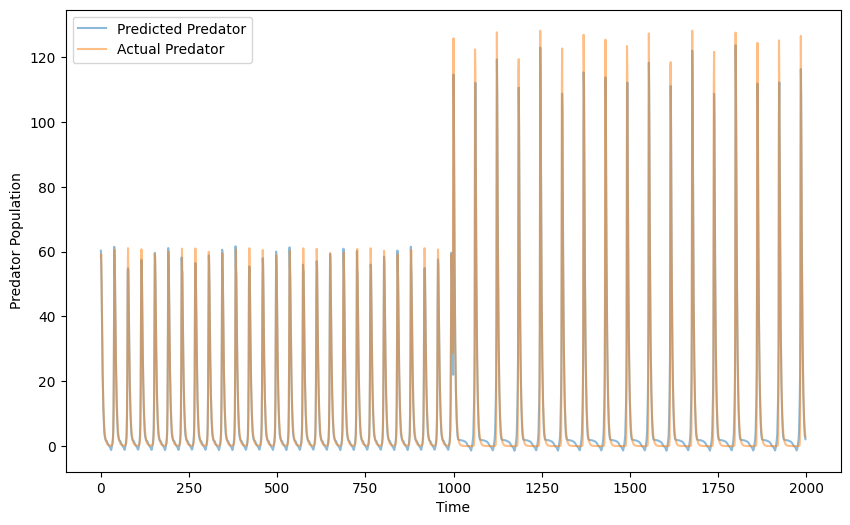

In [43]:
plt.figure(figsize=(10, 6))
plt.plot(range(test_outputs.shape[0]), test_outputs[:,1], label="Predicted Predator", alpha=0.5)
plt.plot(range(test_outputs.shape[0]), testing_data['labels'][:,1], label="Actual Predator", alpha=0.5)
plt.xlabel('Time')
plt.ylabel('Predator Population')
plt.legend()
plt.savefig(os.path.join(task_results_dir, f'pp_mlp_predator_{suffix}.png'))